In [1]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl

from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt

/home/leeh8911/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SAME_DISTRIBUTION = False
HARD_DISTRIBUTION = True

In [3]:
train_batch_size = 16
test_batch_size = 16

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
SEED = 19901109
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
pl.seed_everything(42, workers=True)

torch.backends.cudnn.benchmark = False

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

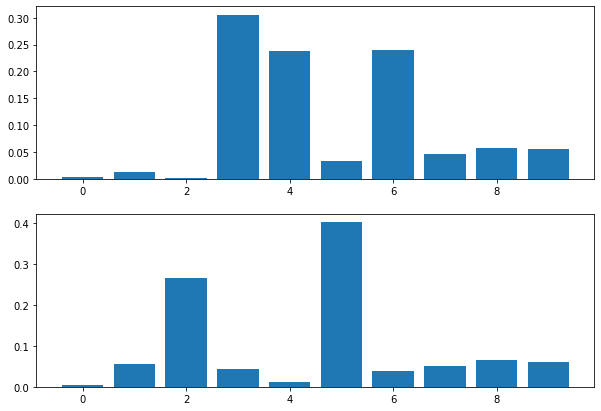

In [7]:
nclass = len(train_dataset.classes)

if SAME_DISTRIBUTION:
    train_dataset_distribution = np.random.rand(nclass)
    test_dataset_distribution = train_dataset_distribution
else:
    train_dataset_distribution = np.random.rand(nclass)
    test_dataset_distribution = np.random.rand(nclass)

if HARD_DISTRIBUTION:
    train_dataset_distribution = train_dataset_distribution ** 3
    test_dataset_distribution = test_dataset_distribution ** 3

train_dataset_distribution /= sum(train_dataset_distribution)
test_dataset_distribution /= sum(test_dataset_distribution)

fig, axes = plt.subplots(2, 1, figsize=(10, 7))
axes[0].bar(range(nclass), train_dataset_distribution)
axes[1].bar(range(nclass), test_dataset_distribution)
plt.show()

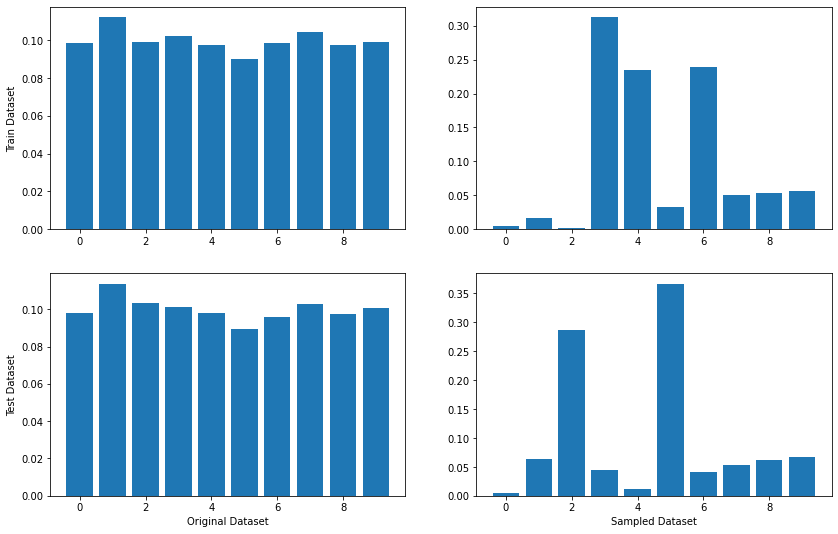

In [8]:
def sampled_datasets(class_weights, dataset):
    data_weight = [class_weights[c] for _, c in dataset]

    sampler = torch.utils.data.WeightedRandomSampler(data_weight, len(dataset))

    samples = [dataset[i] for i in sampler]
    return samples

new_train_dataset = sampled_datasets(train_dataset_distribution, train_dataset)
new_test_dataset = sampled_datasets(test_dataset_distribution, test_dataset)

train_origin_count = np.zeros((nclass, ))
train_new_count = np.zeros((nclass, ))
test_origin_count = np.zeros((nclass, ))
test_new_count = np.zeros((nclass, ))

for _, c in train_dataset:
    train_origin_count[c] += 1

for _, c in new_train_dataset:
    train_new_count[c] += 1

for _, c in test_dataset:
    test_origin_count[c] += 1

for _, c in new_test_dataset:
    test_new_count[c] += 1

train_origin_distribution = train_origin_count / sum(train_origin_count)
train_new_distribution = train_new_count / sum(train_new_count)
test_origin_distribution = test_origin_count / sum(test_origin_count)
test_new_distribution = test_new_count / sum(test_new_count)

fig, axes = plt.subplots(2, 2, figsize=(14, 9))
axes[0][0].bar(range(nclass), train_origin_distribution)
axes[0][1].bar(range(nclass), train_new_distribution)
axes[0][0].set_ylabel("Train Dataset")

axes[1][0].bar(range(nclass), test_origin_distribution)
axes[1][1].bar(range(nclass), test_new_distribution)
axes[1][0].set_ylabel("Test Dataset")
axes[1][0].set_xlabel("Original Dataset")
axes[1][1].set_xlabel("Sampled Dataset")

plt.show()

In [9]:
new_train_dataset, new_valid_dataset = train_test_split(new_train_dataset, test_size=0.1)
print(len(new_train_dataset), len(new_valid_dataset))

54000 6000


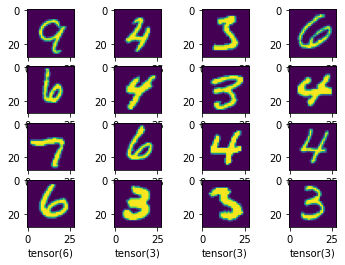

In [10]:

train_loader = DataLoader(new_train_dataset, batch_size=train_batch_size, shuffle=True)

fig, axes = plt.subplots(4, 4)
for batch in train_loader:
    for idx, (X, y) in enumerate(zip(*batch)):
        axes[idx % 4][idx // 4].imshow(X.squeeze(0))
        axes[idx % 4][idx // 4].set_xlabel(y)
    break

plt.show()


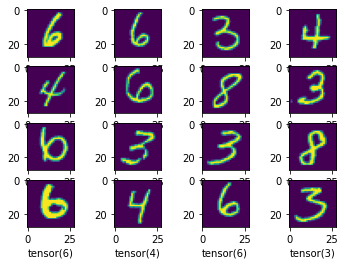

In [11]:
valid_loader = DataLoader(new_valid_dataset, batch_size=train_batch_size, shuffle=True)

fig, axes = plt.subplots(4, 4)
for batch in valid_loader:
    for idx, (X, y) in enumerate(zip(*batch)):
        axes[idx % 4][idx // 4].imshow(X.squeeze(0))
        axes[idx % 4][idx // 4].set_xlabel(y)
    break

plt.show()


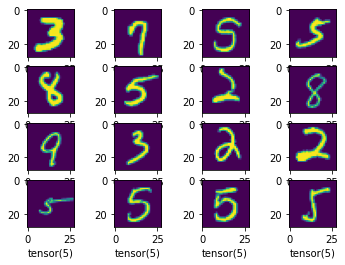

In [12]:

test_loader = DataLoader(new_test_dataset, batch_size=test_batch_size, shuffle=False)

fig, axes = plt.subplots(4, 4)
for batch in test_loader:
    for idx, (X, y) in enumerate(zip(*batch)):
        axes[idx % 4][idx // 4].imshow(X.squeeze(0))
        axes[idx % 4][idx // 4].set_xlabel(y)
    break

plt.show()

In [44]:
class SimpleModelTrainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.cbrm1 = nn.Sequential(nn.Conv2d(1,4,kernel_size=(3,3),padding=1), nn.BatchNorm2d(4), nn.ReLU(), nn.MaxPool2d(2))
        self.cbrm2 = nn.Sequential(nn.Conv2d(4,16,kernel_size=(3,3),padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2))

        self.feature1 = nn.Sequential(nn.Linear(7 * 7 * 16, 128), nn.ReLU())
        self.feature2 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())

        self.classifier = nn.Linear(64, 10)
    
    def forward(self, X):
        if X.dim() == 4:
            B, C, W, H = X.shape
        else:
            B, W, H = X.shape
            X = X.unsqueeze(axis=1)
        X = self.cbrm1(X)
        X = self.cbrm2(X)

        X = self.feature1(X.view(B, -1))
        X = self.feature2(X)

        y = self.classifier(X)
        return y

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        criterion = nn.CrossEntropyLoss()

        loss = criterion(y_hat, y)
        acc = (y == y_hat.argmax(1)).mean()
        logs = {'train_loss':loss.item(), 'train_acc':acc}
        return {'train_loss':loss, 'train_log':logs}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        criterion = nn.CrossEntropyLoss()

        loss = criterion(y_hat, y)
        acc = (y == y_hat.argmax(1)).float().mean()
        logs = {'valid_loss':loss.item(), 'valid_acc':acc}
        return {'valid_loss':loss, 'valid_log':logs}
        
    def validation_epoch_end(self, outputs):
        print(outputs)
        # called at the end of the validation epoch
        # outputs is an array with what you returned in validation_step for each batch
        # outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}] 
        train_loss = torch.stack([x['train_log']['train_loss'] for x in outputs]).mean()
        train_acc = torch.stack([x['train_log']['train_acc'] for x in outputs]).mean()
        valid_loss = torch.stack([x['valid_log']['valid_loss'] for x in outputs]).mean()
        valid_acc = torch.stack([x[['valid_log']'valid_acc'] for x in outputs]).mean()
        tensorboard_logs = {'train_loss':train_loss, 'train_acc':train_acc, 'valid_loss':valid_loss, 'valid_acc':valid_acc}
        return {'avg_val_loss': valid_acc, 'log': tensorboard_logs}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
        

In [45]:

model = SimpleModelTrainer()
trainer = pl.Trainer(accelerator='gpu',
check_val_every_n_epoch=1,
enable_checkpointing=True,
max_epochs=100)
trainer.fit(model, train_loader, valid_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | cbrm1      | Sequential | 48    
1 | cbrm2      | Sequential | 624   
2 | feature1   | Sequential | 100 K 
3 | feature2   | Sequential | 8.3 K 
4 | classifier | Linear     | 650   
------------------------------------------
110 K     Trainable params
0         Non-trainable params
110 K     Total params
0.440     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 720.30it/s]

/home/leeh8911/anaconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/home/leeh8911/anaconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


[{'loss': tensor(2.2398, device='cuda:0'), 'log': {'valid_loss': 2.2398159503936768, 'valid_acc': tensor(0.3750, device='cuda:0')}}, {'loss': tensor(2.2365, device='cuda:0'), 'log': {'valid_loss': 2.236523151397705, 'valid_acc': tensor(0.2500, device='cuda:0')}}]


KeyError: 'train_loss'